# SIGKDD multi-dataset time series anomaly detection (TSAD) contest

We use only some of the Phase I datasets and our own hand-crafted labels.

This notebook and the datasets are superseded by the _SIGKDD21 TSAD Competition_ datasets!

In [50]:
from typing import List
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from config import data_raw_folder, data_processed_folder
from timeeval import Datasets, DatasetRecord
from timeeval.datasets import DatasetAnalyzer

In [51]:
plt.rcParams["figure.figsize"] = (20, 10)

In [52]:
def find_datasets(folder):
    if not isinstance(folder, Path):
        folder = Path(folder)
    return sorted([f for f in folder.glob("*.csv") if f.is_file()])

def plot_dataset(f, with_split=True):
    name = f.stem
    split_at = int(f.stem.split("_")[-1])
    data = np.genfromtxt(f)
    if with_split:
        train = np.full_like(data, fill_value=np.nan)
        train[:split_at] = data[:split_at]
        test = np.full_like(data, fill_value=np.nan)
        test[split_at:] = data[split_at:]
        plt.plot(train, label="train", color="red")
        plt.plot(test, label="test", color="green")
    else:
        plt.plot(data, label=name, color="black")
    plt.title(name)
    return data

anomaly_ranges = {
    "3": (5450, 5450+200),
    "10": (11900, 11900+100),
    "11": (15995, 15995+110),
    "12": (15995, 15995+110),
    "13": (17000, 17000+70),
    "14": (16700, 16700+200),
    "15": (16890, 16890+200),
    "16": (16890, 16890+200),
    "17": (16890, 16890+200),
    "18": (6150, 6150+70),
    "19": (7130, 7130+250),
    "20": (5945, 5945+50),
    "21": (6520, 6520+120),
    "22": (8610, 8610+110),
    "24": (5570, 5570+80),
}

In [53]:
dataset_collection_name = "KDD-TSAD"
source_folder = Path(data_raw_folder) / "KDD-TSAD-contest" / "PhaseI"
target_folder = Path(data_processed_folder)

print(f"Looking for source datasets in {Path(source_folder).absolute()} and\nsaving processed datasets in {Path(target_folder).absolute()}")

Looking for source datasets in /home/sebastian/Documents/projects/timeeval/notebooks/data-prep/../../datasets/KDD-TSAD-contest/PhaseI and
saving processed datasets in /home/sebastian/Documents/projects/timeeval/notebooks/data-prep/../../datasets/data-processed


In [57]:
# shared by all datasets
dataset_type = "real"
input_type = "univariate"
datetime_index = False
split_at = None
train_is_normal = True
train_type = "semi-supervised"

# create target directory
dataset_subfolder = Path(input_type) / dataset_collection_name
target_subfolder = target_folder / dataset_subfolder
target_subfolder.mkdir(parents=True, exist_ok=True)
print(f"Created directories {target_subfolder}")

dm = Datasets(target_folder)

Created directories ../../datasets/data-processed/univariate/KDD-TSAD


In [55]:
def process_dataset(dm: Datasets, idx: int, f: Path) -> None:
    name_parts = f.stem.split("_")
    dataset_name = "_".join(name_parts[:-1])
    split_at = int(name_parts[-1])
    test_filename = f"{dataset_name}.test.csv"
    train_filename = f"{dataset_name}.train.csv"
    test_path = dataset_subfolder / test_filename
    train_path = dataset_subfolder / train_filename
    target_test_filepath = target_subfolder / test_filename
    target_train_filepath = target_subfolder / train_filename
    target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_PREFIX}"

    # Prepare datasets
    data = np.genfromtxt(f)
    anomaly = anomaly_ranges[str(idx)]
    df_test = pd.DataFrame(data, columns=["value"])
    df_test.insert(0, "timestamp", df_test.index.values)
    df_test["is_anomaly"] = 0
    df_test.loc[range(anomaly[0], anomaly[1]), "is_anomaly"] = 1
    df_test.to_csv(target_test_filepath, index=False)

    df_train = df_test[:split_at].copy()
    df_train.to_csv(target_train_filepath, index=False)
    print(f"Processed training dataset {idx}: {f} -> {target_train_filepath}")

    # Prepare metadata
    da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test)
    da.save_to_json(target_meta_filepath, overwrite=True)
    meta = da.metadata

    DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=True, df=df_train)\
        .save_to_json(target_meta_filepath, overwrite=False)

    dm.add_dataset(DatasetRecord(
          collection_name=dataset_collection_name,
          dataset_name=dataset_name,
          train_path=train_path,
          test_path=test_path,
          dataset_type=dataset_type,
          datetime_index=datetime_index,
          split_at=split_at,
          train_type=train_type,
          train_is_normal=train_is_normal,
          input_type=input_type,
          length=meta.length,
          dimensions=meta.dimensions,
          contamination=meta.contamination,
          num_anomalies=meta.num_anomalies,
          min_anomaly_length=meta.anomaly_length.min,
          median_anomaly_length=meta.anomaly_length.median,
          max_anomaly_length=meta.anomaly_length.max,
          mean=meta.mean,
          stddev=meta.stddev,
          trend=meta.trend,
          stationarity=meta.get_stationarity_name(),
    ))
    print(f"Processed source dataset {idx}: {f} -> {target_test_filepath}")

for i, file in enumerate(find_datasets(source_folder)):
    if str(i) in anomaly_ranges:
        process_dataset(dm, i, file)
    else:
        print(f"Skipped source dataset {i}: {file}, because we have no labels for it!")
dm.save()

Skipped source dataset 0: ../../datasets/KDD-TSAD-contest/PhaseI/001_UCR_Anomaly_35000.csv, because we have no labels for it!
Skipped source dataset 1: ../../datasets/KDD-TSAD-contest/PhaseI/002_UCR_Anomaly_35000.csv, because we have no labels for it!
Skipped source dataset 2: ../../datasets/KDD-TSAD-contest/PhaseI/003_UCR_Anomaly_35000.csv, because we have no labels for it!
Processed training dataset 3: ../../datasets/KDD-TSAD-contest/PhaseI/004_UCR_Anomaly_2500.csv -> ../../datasets/data-processed/univariate/KDD-TSAD/004_UCR_Anomaly.train.csv
Processed source dataset 3: ../../datasets/KDD-TSAD-contest/PhaseI/004_UCR_Anomaly_2500.csv -> ../../datasets/data-processed/univariate/KDD-TSAD/004_UCR_Anomaly.test.csv
Skipped source dataset 4: ../../datasets/KDD-TSAD-contest/PhaseI/005_UCR_Anomaly_4000.csv, because we have no labels for it!
Skipped source dataset 5: ../../datasets/KDD-TSAD-contest/PhaseI/006_UCR_Anomaly_4000.csv, because we have no labels for it!
Skipped source dataset 6: ../

In [58]:
dm.refresh()
dm.df().loc[(slice(dataset_collection_name,dataset_collection_name), slice(None))]

train_path  \
collection_name dataset_name                                                     
KDD-TSAD        004_UCR_Anomaly  univariate/KDD-TSAD/004_UCR_Anomaly.train.csv   
                011_UCR_Anomaly  univariate/KDD-TSAD/011_UCR_Anomaly.train.csv   
                012_UCR_Anomaly  univariate/KDD-TSAD/012_UCR_Anomaly.train.csv   
                013_UCR_Anomaly  univariate/KDD-TSAD/013_UCR_Anomaly.train.csv   
                014_UCR_Anomaly  univariate/KDD-TSAD/014_UCR_Anomaly.train.csv   
                015_UCR_Anomaly  univariate/KDD-TSAD/015_UCR_Anomaly.train.csv   
                016_UCR_Anomaly  univariate/KDD-TSAD/016_UCR_Anomaly.train.csv   
                017_UCR_Anomaly  univariate/KDD-TSAD/017_UCR_Anomaly.train.csv   
                018_UCR_Anomaly  univariate/KDD-TSAD/018_UCR_Anomaly.train.csv   
                019_UCR_Anomaly  univariate/KDD-TSAD/019_UCR_Anomaly.train.csv   
                020_UCR_Anomaly  univariate/KDD-TSAD/020_UCR_Anomaly.train.csv   
                021_UCR_Anomaly  univariate/KDD-TSAD/021_UCR_Anomaly.train.csv   
                022_UCR_Anomaly  univariate/KDD-TSAD/022_UCR_Anomaly.train.csv   
                023_UCR_Anomaly  univariate/KDD-TSAD/023_UCR_Anomaly.train.csv   
                025_UCR_Anomaly  univariate/KDD-TSAD/025_UCR_Anomaly.train.csv   

                                                                    test_path  \
collection_name dataset_name                                                    
KDD-TSAD        004_UCR_Anomaly  univariate/KDD-TSAD/004_UCR_Anomaly.test.csv   
                011_UCR_Anomaly  univariate/KDD-TSAD/011_UCR_Anomaly.test.csv   
                012_UCR_Anomaly  univariate/KDD-TSAD/012_UCR_Anomaly.test.csv   
                013_UCR_Anomaly  univariate/KDD-TSAD/013_UCR_Anomaly.test.csv   
                014_UCR_Anomaly  univariate/KDD-TSAD/014_UCR_Anomaly.test.csv   
                015_UCR_Anomaly  univariate/KDD-TSAD/015_UCR_Anomaly.test.csv   
                016_UCR_Anomaly  univariate/KDD-TSAD/016_UCR_Anomaly.test.csv   
                017_UCR_Anomaly  univariate/KDD-TSAD/017_UCR_Anomaly.test.csv   
                018_UCR_Anomaly  univariate/KDD-TSAD/018_UCR_Anomaly.test.csv   
                019_UCR_Anomaly  univariate/KDD-TSAD/019_UCR_Anomaly.test.csv   
                020_UCR_Anomaly  univariate/KDD-TSAD/020_UCR_Anomaly.test.csv   
                021_UCR_Anomaly  univariate/KDD-TSAD/021_UCR_Anomaly.test.csv   
                022_UCR_Anomaly  univariate/KDD-TSAD/022_UCR_Anomaly.test.csv   
                023_UCR_Anomaly  univariate/KDD-TSAD/023_UCR_Anomaly.test.csv   
                025_UCR_Anomaly  univariate/KDD-TSAD/025_UCR_Anomaly.test.csv   

                                dataset_type  datetime_index  split_at  \
collection_name dataset_name                                             
KDD-TSAD        004_UCR_Anomaly         real           False    2500.0   
                011_UCR_Anomaly         real           False   10000.0   
                012_UCR_Anomaly         real           False   15000.0   
                013_UCR_Anomaly         real           False   15000.0   
                014_UCR_Anomaly         real           False    8000.0   
                015_UCR_Anomaly         real           False    5000.0   
                016_UCR_Anomaly         real           False    5000.0   
                017_UCR_Anomaly         real           False    5000.0   
                018_UCR_Anomaly         real           False    8000.0   
                019_UCR_Anomaly         real           False    5000.0   
                020_UCR_Anomaly         real           False    5000.0   
                021_UCR_Anomaly         real           False    5000.0   
                022_UCR_Anomaly         real           False    4000.0   
                023_UCR_Anomaly         real           False    5000.0   
                025_UCR_Anomaly         real           False    2800.0   

                                    

## Exploration

In [7]:
datasets = find_datasets(source_folder)
datasets

[PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/001_UCR_Anomaly_35000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/002_UCR_Anomaly_35000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/003_UCR_Anomaly_35000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/004_UCR_Anomaly_2500.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/005_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/006_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/007_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/008_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/009_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/010_UCR_Anomaly_4000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/011_UCR_Anomaly_10000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/PhaseI/012_UCR_Anomaly_15000.csv'),
 PosixPath('../../datasets/KDD-TSAD-contest/Pha

In [33]:
f = datasets[3]
data = np.genfromtxt(f)
anomaly = anomaly_ranges["3"]
split_at = int(f.stem.split("_")[-1])
df = pd.DataFrame(data, columns=["value"])
df["is_anomaly"] = 0
df.loc[range(anomaly[0], anomaly[1]), "is_anomaly"] = 1
df

,value,is_anomaly
0,-2785.9403,0
1,-3228.5676,0
2,-3528.9955,0
3,-4226.8308,0
4,-4508.2635,0
...,...,...
10995,-6557.2874,0
10996,-7272.4743,0
10997,-7733.4130,0
10998,-7973.6916,0


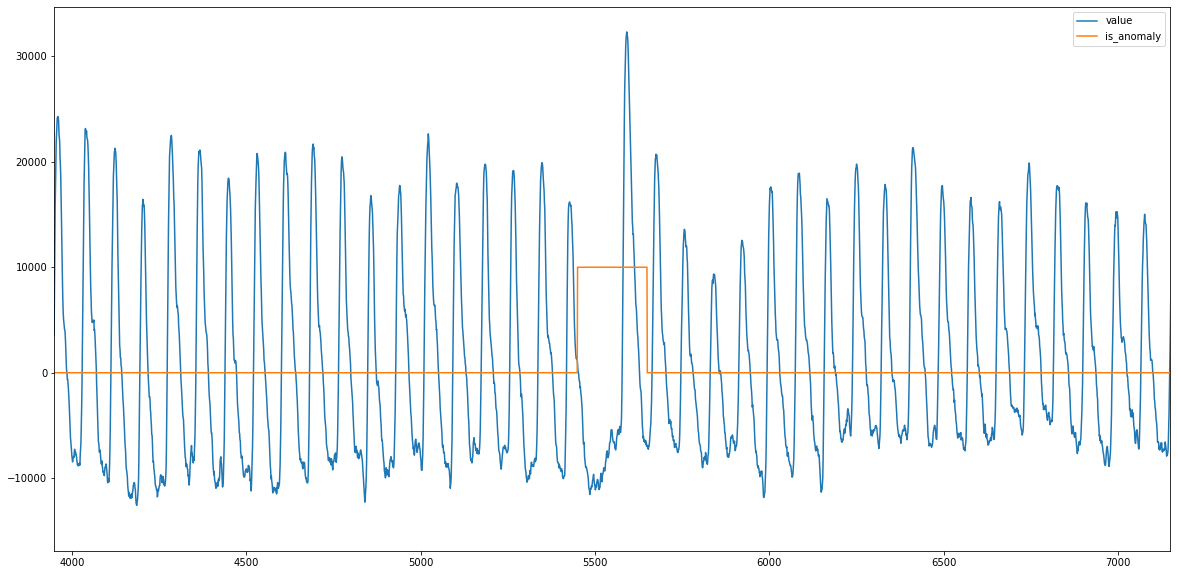

In [34]:
df.plot()
plt.xlim(anomaly[0]-1500, anomaly[1]+1500)
plt.show()

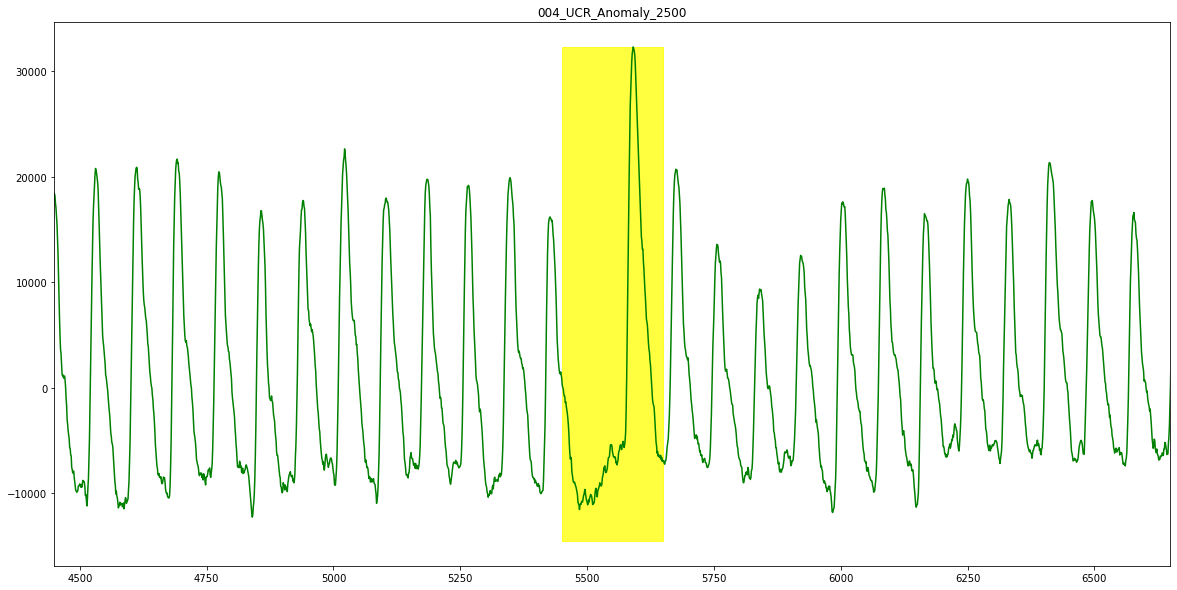

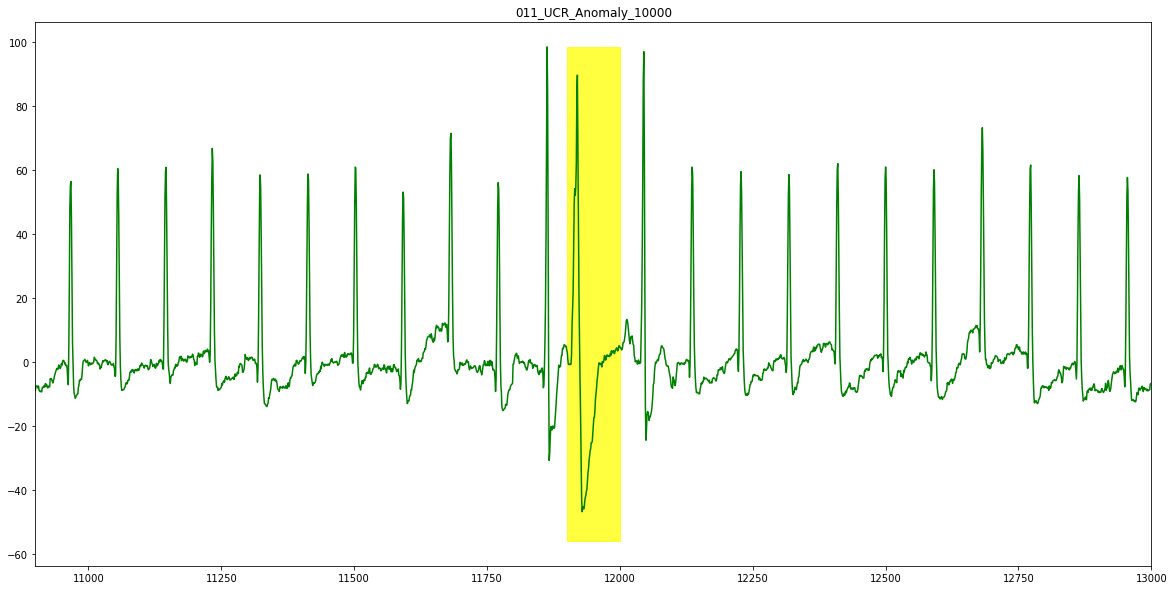

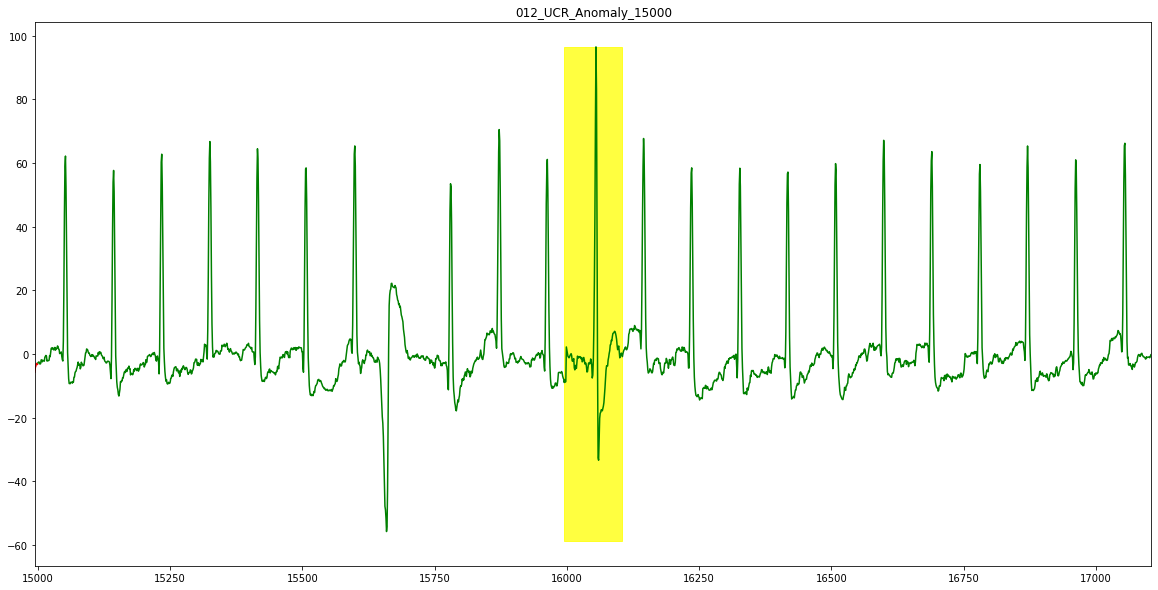

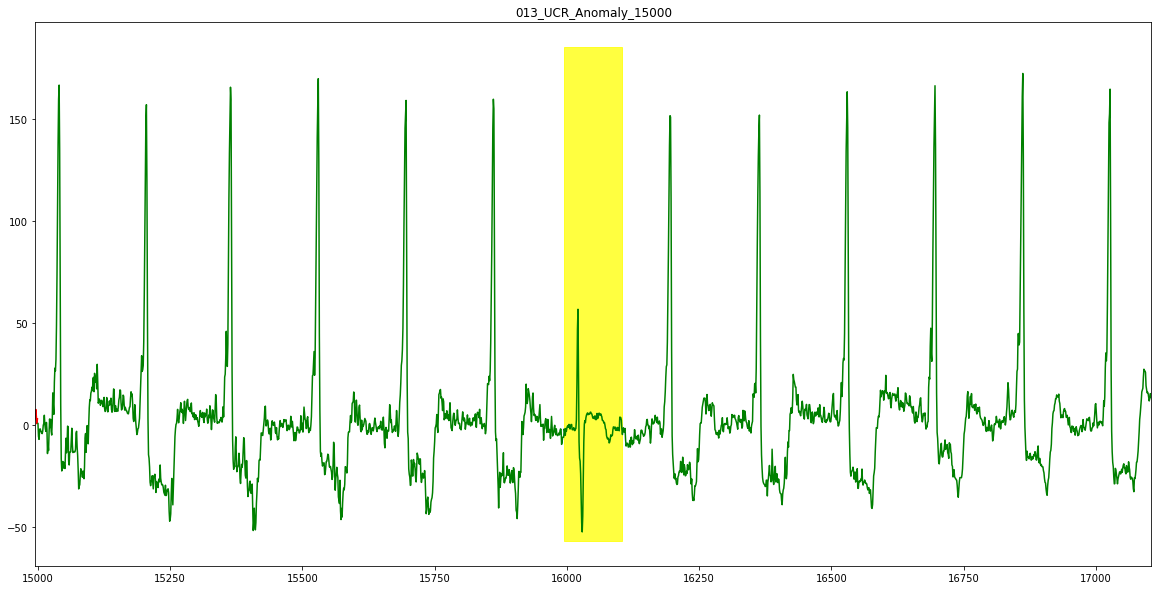

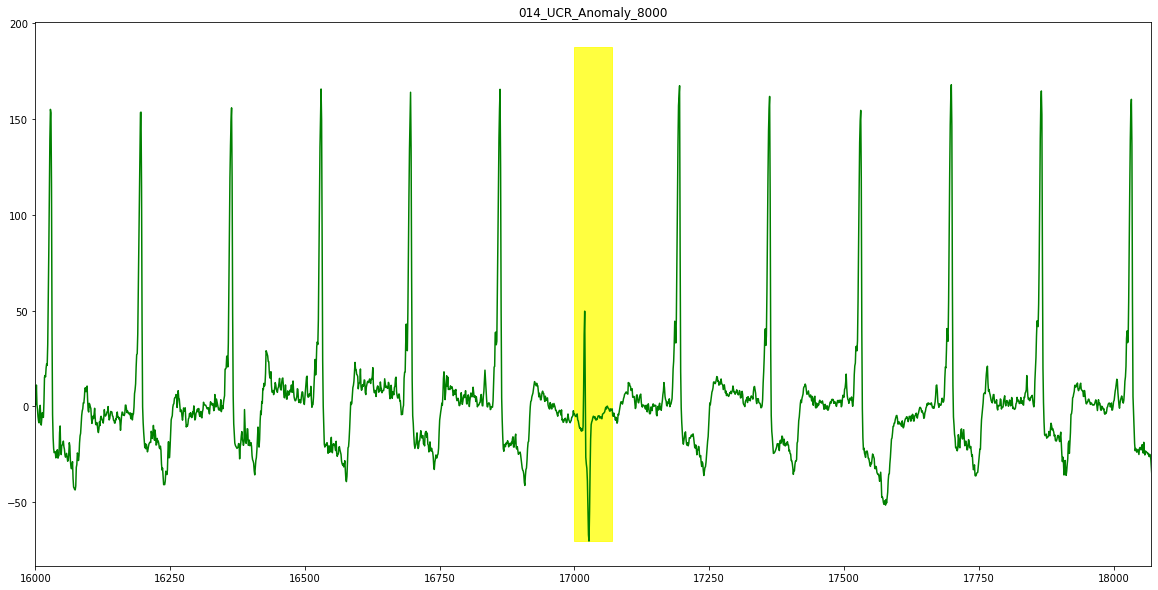

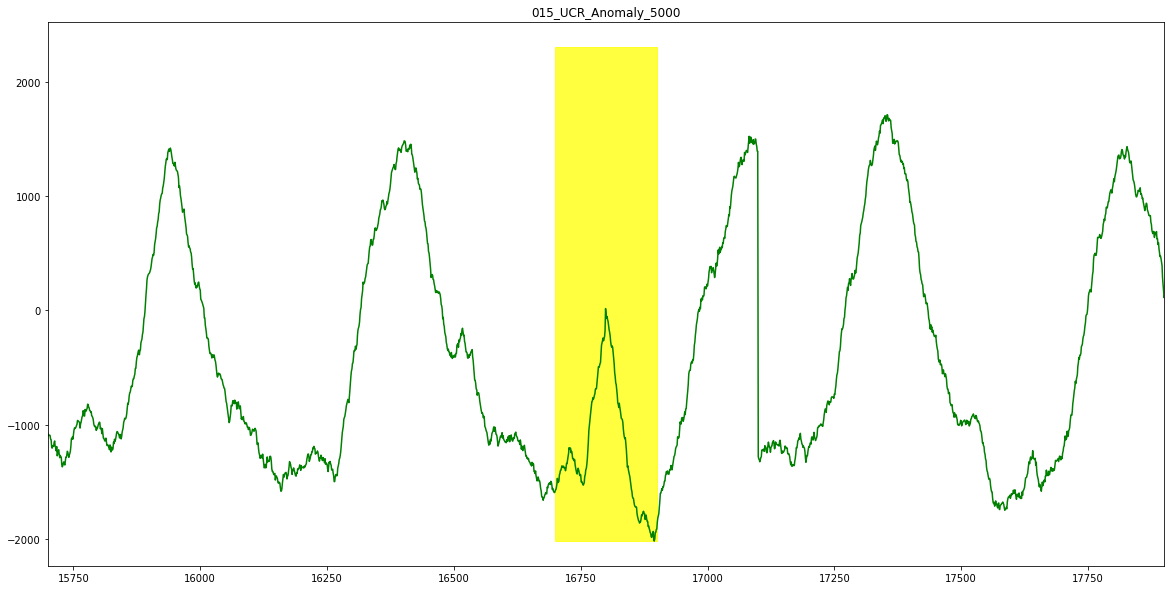

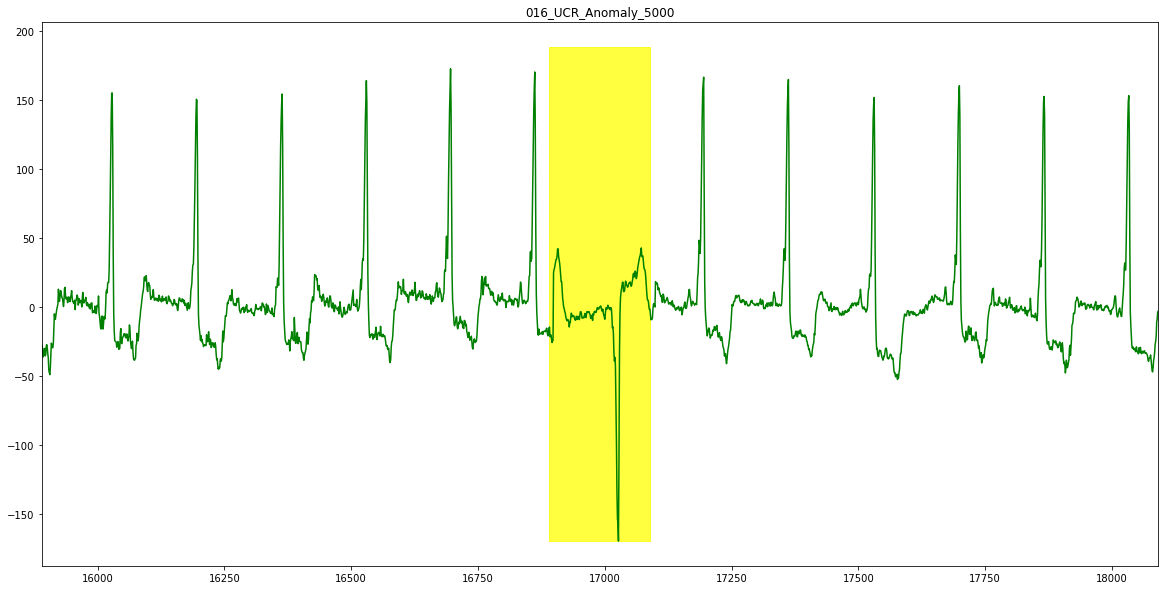

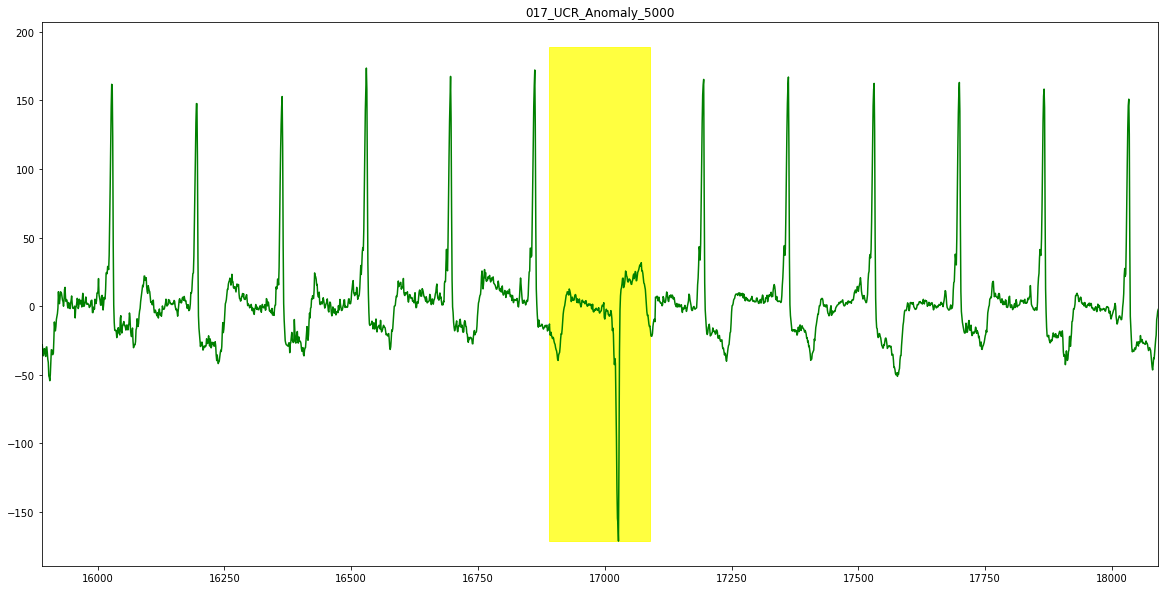

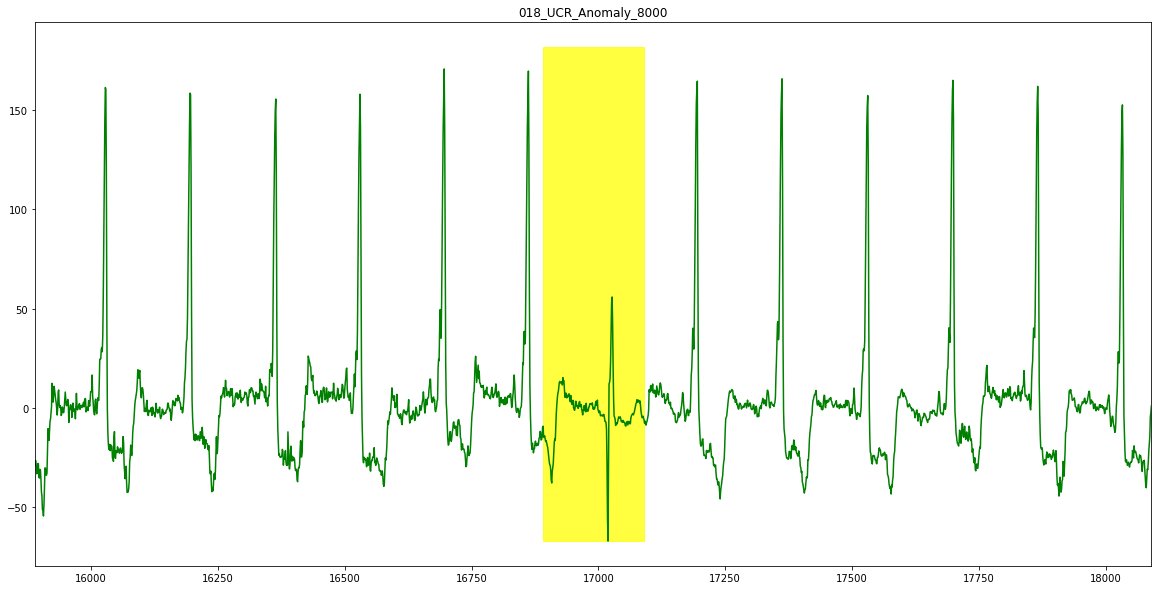

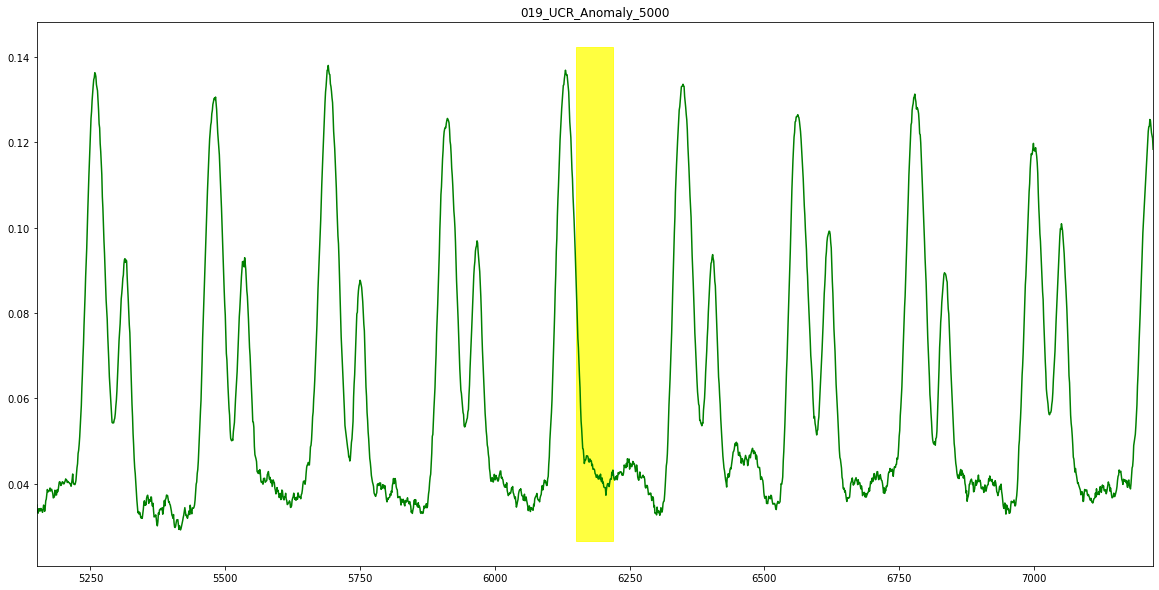

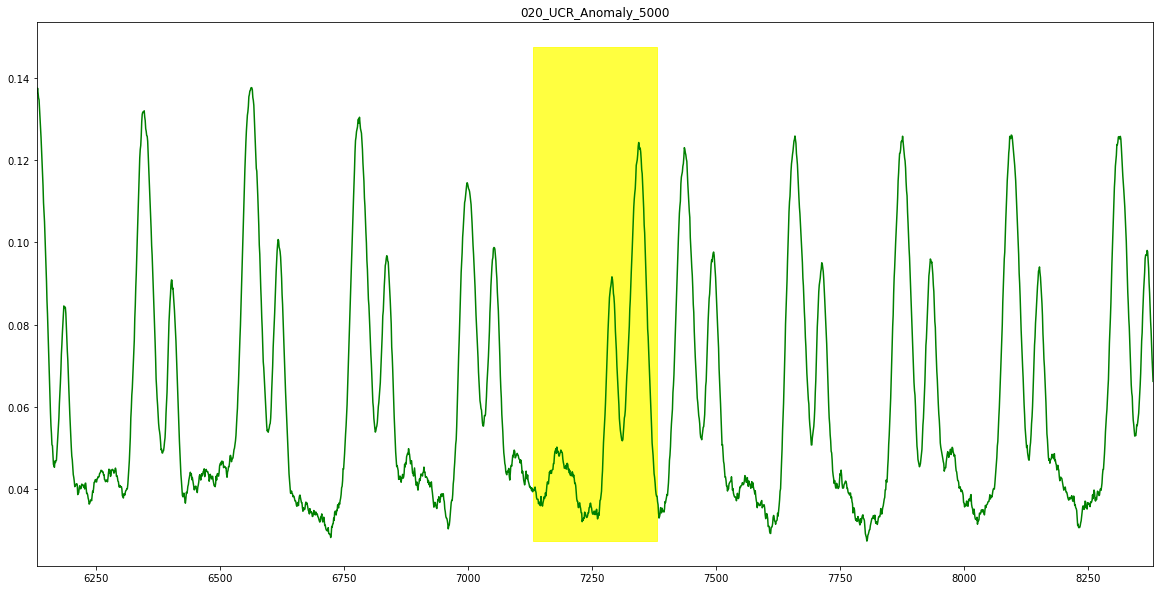

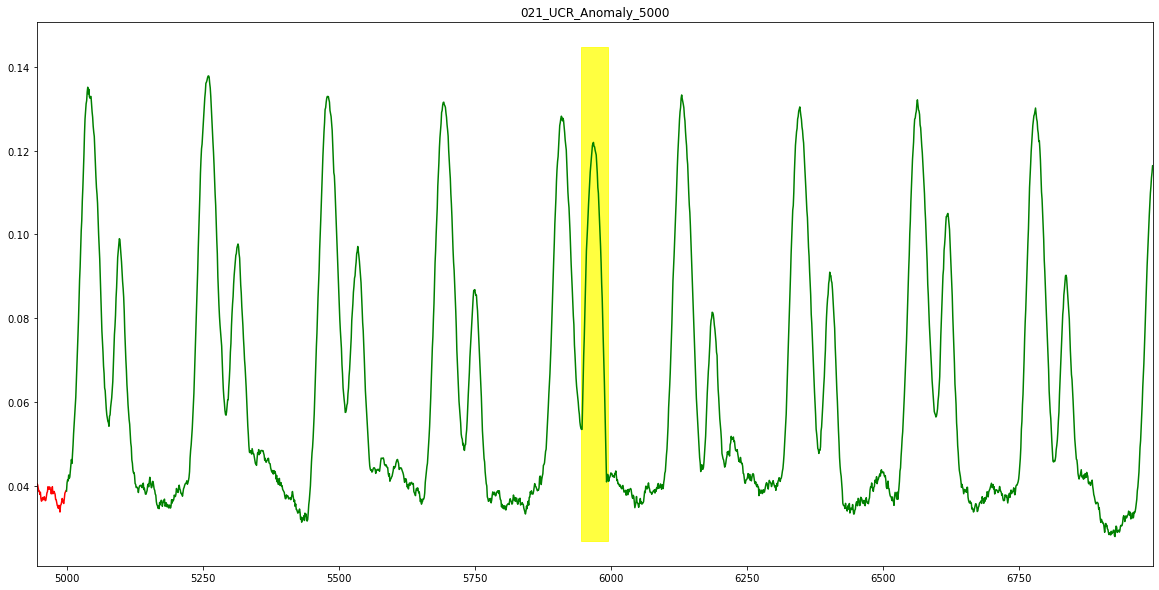

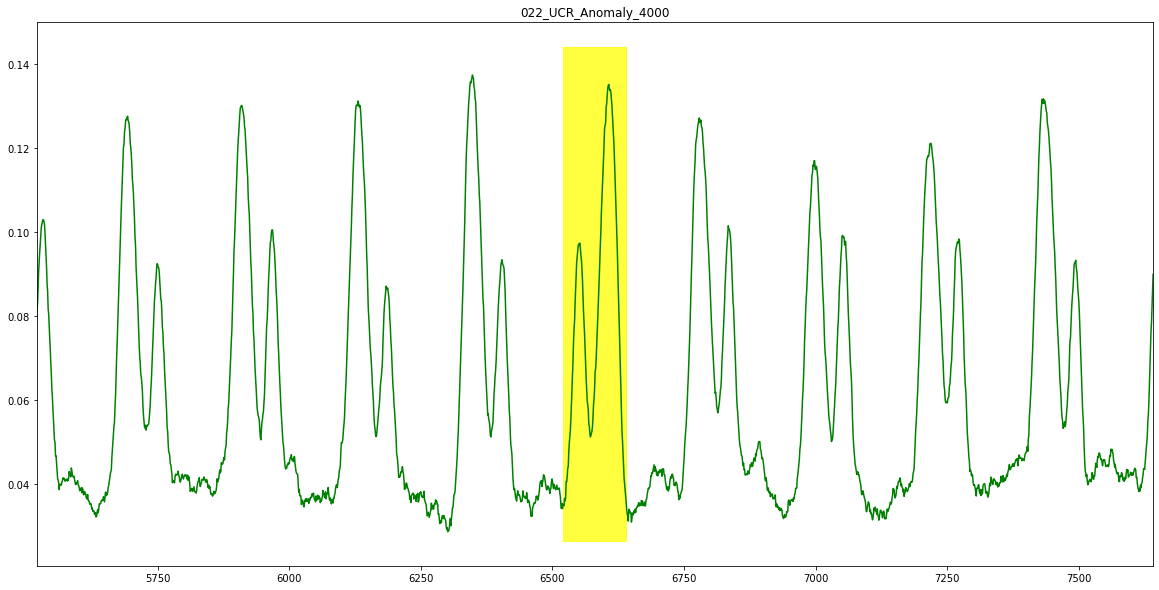

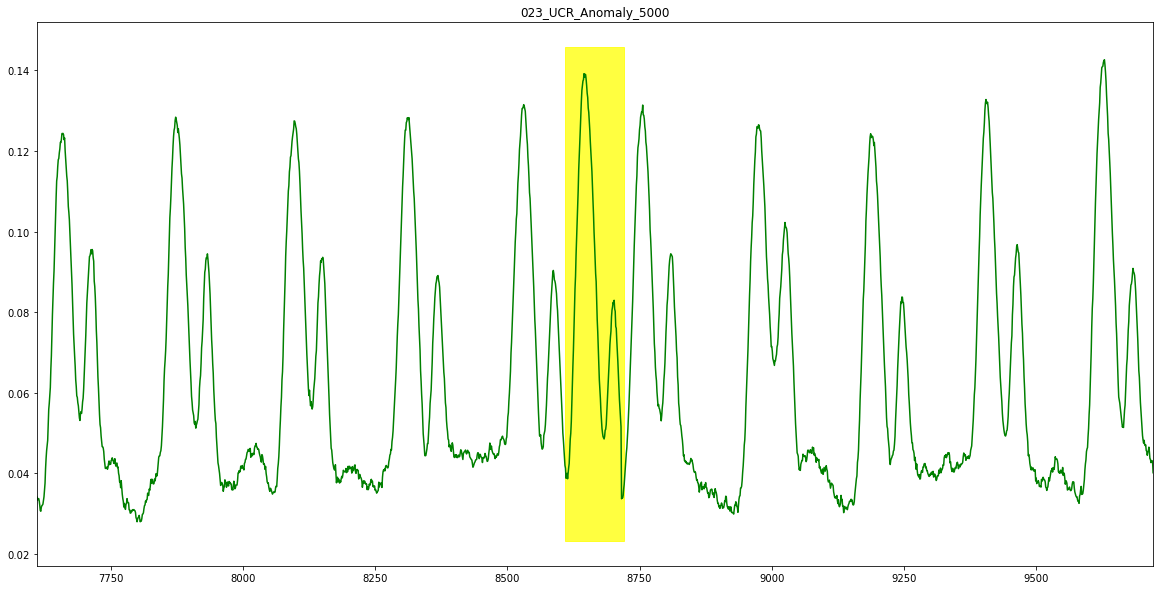

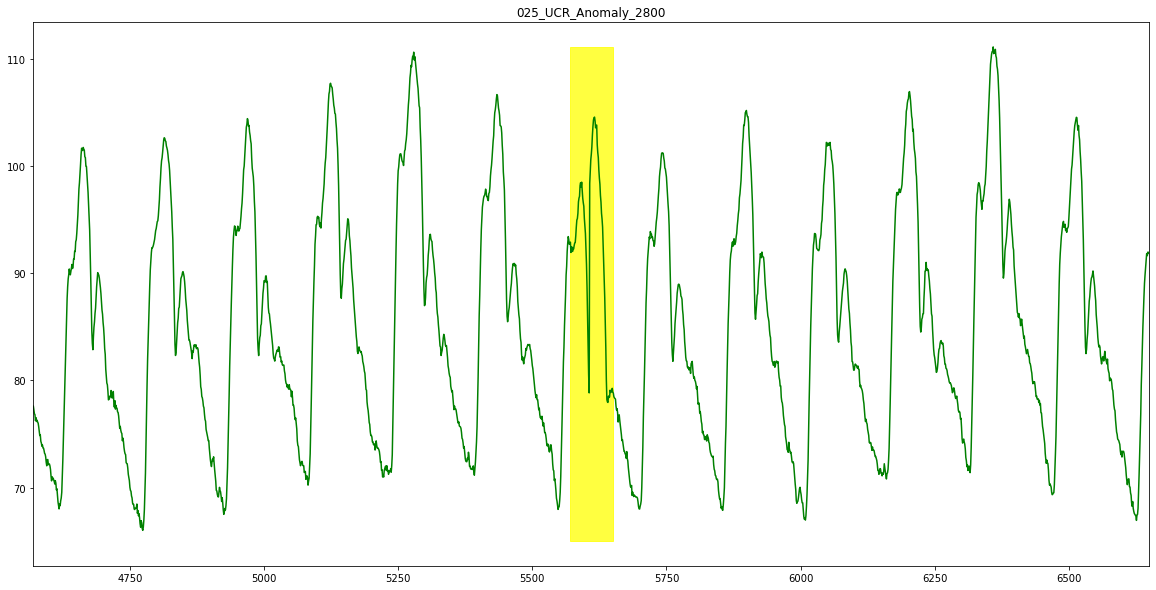

In [43]:
for i, f in enumerate(find_datasets(source_folder)):
    if str(i) in anomaly_ranges:
        anomaly = anomaly_ranges[str(i)]
        plt.figure()
        ax = plt.axes()
        data = plot_dataset(f)
        ax.add_patch(matplotlib.patches.Rectangle((anomaly[0],data.min()), anomaly[1]-anomaly[0], data.max()-data.min(), color="yellow", alpha=0.75))
        plt.xlim(anomaly[0]-1000, anomaly[1]+1000)
        plt.show()